In [9]:
import keras

Using TensorFlow backend.


In [11]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from keras import models, layers, optimizers, regularizers

In [13]:
df = pd.read_csv('listings2.csv')
df = df.rename(columns={'neighbourhood_group_cleansed':'neighbourhood_group'})

## Let's get an overview of the data

In [14]:
print(df.columns)
nulls = df.isna().sum()
print(nulls)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_fe

### After doing some research, I found that the best features to use are categorical and numerical so we'll drop text columns 

In [15]:
text_cols_to_drop = ['listing_url', 'scrape_id',
                'last_scraped', 'name', 'summary', 'space',
                'description', 'neighborhood_overview', 'notes', 'transit',
                'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name',
                'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
                'host_verifications',
                'calendar_last_scraped', 'amenities']
df = df.drop(text_cols_to_drop, axis=1, inplace=False)

## We'll also get rid of the columns that contain too many nan's

In [16]:
df = df.drop(['host_acceptance_rate',
         'square_feet', 'weekly_price', 'monthly_price', 'license',
         'jurisdiction_names', 'experiences_offered'], axis=1, inplace=False)

## Some columns also contain mostly the same data so we can drop those

In [17]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))

2


In [18]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count'],
        axis=1, inplace=True)

### For nans in bathrooms, bedrooms, and beds, they can be replaced with the median

In [19]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

### Price features contain dollar signs and decimals which will be converted to int64s

In [20]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people = df.extra_people.astype('int64')

### For availability 30, 60, 90, and 365, we'll get rid of all but one since including all of them won't help the model

In [21]:
df = df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1)

### Since reviews per month is too correlated with number of reviews we can delete it

In [22]:
df = df.drop(['reviews_per_month'], axis=1, inplace=False)

### Since many listings don't have reviews yet, we can drop review score features

In [23]:
df = df.drop(['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
              'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'], axis=1)

In [24]:
# Quick Check
print(df.isna().sum())

id                                     0
host_since                             2
host_response_time                   523
host_response_rate                   523
host_is_superhost                      2
host_listings_count                    2
host_has_profile_pic                   2
host_identity_verified                 2
street                                 0
neighbourhood                        416
neighbourhood_cleansed                 0
neighbourhood_group                    0
city                                   0
state                                  0
zipcode                                7
market                                 0
smart_location                         0
country_code                           0
country                                0
latitude                               0
longitude                              0
is_location_exact                      0
property_type                          1
room_type                              0
accommodates    

### Finally, we can drop the last columns with nan's and we drop other columns that aren't useful for testing

In [25]:
useless = ['id', 'host_is_superhost', 'host_since', 'host_listings_count', 'host_identity_verified', 'city', 'state',
           'country_code', 'neighbourhood', 'neighbourhood_cleansed', 'security_deposit', 'cleaning_fee',
           'street', 'country']
df = df.drop(useless, axis=1)

In [72]:
print(df.columns)

Index(['host_response_time', 'host_response_rate', 'host_has_profile_pic',
       'neighbourhood_group', 'zipcode', 'market', 'smart_location',
       'latitude', 'longitude', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'price', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'has_availability', 'availability_90', 'number_of_reviews',
       'first_review', 'last_review', 'requires_license', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification'],
      dtype='object')


### Since many property types are basically the same, we can also change those

In [26]:
print(df.property_type.value_counts())

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Chalet                2
Dorm                  2
Yurt                  1
Name: property_type, dtype: int64


In [27]:
df['property_type'] = df.property_type.replace({
    'Townhouse': 'House',
    'Bungalow': 'House',
    'Loft': 'Apartment',
    'Chalet': 'Cabin'})

### Checking feature uniqueness

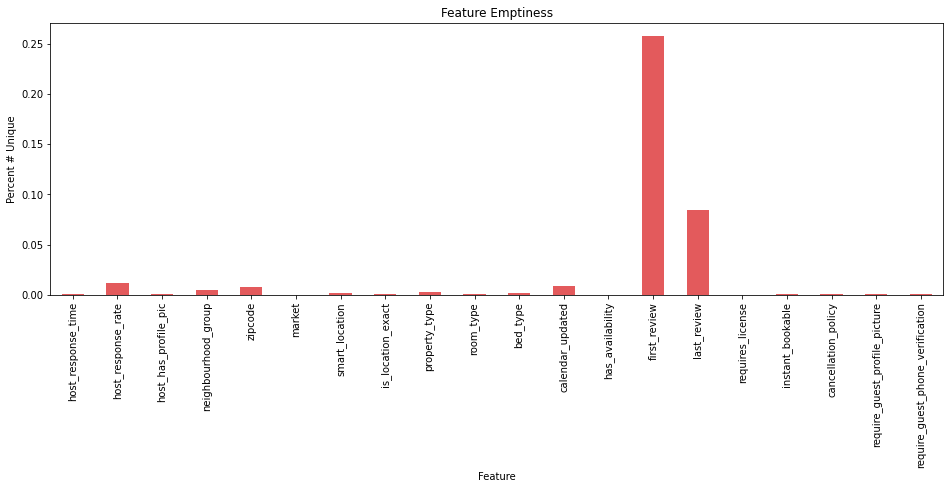

In [28]:
categories = df.columns[df.dtypes == 'object']
percentage_unique = df[categories].nunique() / df.shape[0]
ax = percentage_unique.plot(kind = 'bar', color='#E35A5C', figsize = (16, 5))
ax.set_xlabel('Feature')
ax.set_ylabel('Percent # Unique')
ax.set_title('Feature Emptiness')
plt.show()

### We can now encode categorical variables and log transform numerical variables

In [29]:
transformed_df = pd.get_dummies(df)
to_drop = ['beds',
           'bedrooms',
           'guests_included',
           'room_type_Private room']

numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'extra_people',
                     'host_days_active', 'maximum_nights', 'minimum_nights', 'number_of_reviews',
                     'price']

numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']]

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01 because log(0) undefined
    transformed_df[col] = np.log(transformed_df[col])

### The data is now suitable for testing. ML algoriththms will first be tested and then the neural nets so we have a good baseline

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)    # random state 0 means results will less reproducible

In [31]:
# Defining a function so testing multiple models is easier
def ModelResults(classifier):
    classifier.fit(X_train, y_train)
    train_predict = classifier.predict(X_train)
    test_predict = classifier.predict(X_test)
    print("\nR^2 Train:", r2_score(y_train, train_predict))
    print("R^2 Test:", r2_score(y_test, test_predict))
    
ETR = ExtraTreesRegressor(max_depth=17, n_estimators=100, n_jobs=-1)
RFR = RandomForestRegressor(max_depth=17, n_estimators=100, n_jobs=-1)
GBR = GradientBoostingRegressor(n_estimators=200, learning_rate=0.2)
ModelResults(ETR)
ModelResults(RFR)
ModelResults(GBR)


R^2 Train: 0.9425902948214209
R^2 Test: 0.7271076524702683

R^2 Train: 0.9377181522883529
R^2 Test: 0.7492966585414154

R^2 Train: 0.8367358296539735
R^2 Test: 0.7481003729783153


Random Forest wins by a small margin

### Now, neural nets will be tested

In [32]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

In [33]:
nn3 = models.Sequential()
nn3.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.001), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
nn3.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

nn3_history = nn3.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)
nn_model_evaluation(nn3)

Train on 2748 samples, validate on 306 samples
Epoch 1/150
2748/2748 [==============================] - 1s 394us/step - loss: 23.5740 - mean_squared_error: 6.8550 - val_loss: 19.5062 - val_mean_squared_error: 3.3853
Epoch 2/150
2748/2748 [==============================] - 1s 191us/step - loss: 17.8404 - mean_squared_error: 2.1372 - val_loss: 16.6171 - val_mean_squared_error: 1.4876
Epoch 3/150
2748/2748 [==============================] - 1s 188us/step - loss: 15.5001 - mean_squared_error: 0.8259 - val_loss: 15.1621 - val_mean_squared_error: 1.0830
Epoch 4/150
2748/2748 [==============================] - 1s 199us/step - loss: 13.9711 - mean_squared_error: 0.3725 - val_loss: 13.9383 - val_mean_squared_error: 0.9303
Epoch 5/150
2748/2748 [==============================] - 1s 213us/step - loss: 12.7380 - mean_squared_error: 0.1855 - val_loss: 12.9535 - val_mean_squared_error: 0.9458
Epoch 6/150
2748/2748 [==============================] - 1s 260us/step - loss: 11.7170 - mean_squared_error:

Epoch 98/150
2748/2748 [==============================] - 0s 161us/step - loss: 0.3148 - mean_squared_error: 0.0362 - val_loss: 0.3887 - val_mean_squared_error: 0.1146
Epoch 99/150
2748/2748 [==============================] - 0s 171us/step - loss: 0.3062 - mean_squared_error: 0.0352 - val_loss: 0.3772 - val_mean_squared_error: 0.1101
Epoch 100/150
2748/2748 [==============================] - 0s 163us/step - loss: 0.2985 - mean_squared_error: 0.0342 - val_loss: 0.3695 - val_mean_squared_error: 0.1093
Epoch 101/150
2748/2748 [==============================] - 0s 164us/step - loss: 0.2907 - mean_squared_error: 0.0334 - val_loss: 0.3661 - val_mean_squared_error: 0.1130
Epoch 102/150
2748/2748 [==============================] - 1s 183us/step - loss: 0.2823 - mean_squared_error: 0.0327 - val_loss: 0.3606 - val_mean_squared_error: 0.1150
Epoch 103/150
2748/2748 [==============================] - 0s 180us/step - loss: 0.2749 - mean_squared_error: 0.0321 - val_loss: 0.3523 - val_mean_squared_er

In [34]:
nn4 = models.Sequential()
nn4.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='SGD',
            metrics=['mean_squared_error'])

nn4_history = nn4.fit(X_train,
                  y_train,
                  epochs=200,
                  batch_size=256,
                  validation_split = 0.1)

nn_model_evaluation(nn4)

Train on 2748 samples, validate on 306 samples
Epoch 1/200
2748/2748 [==============================] - 1s 242us/step - loss: 93.5363 - mean_squared_error: 8.1561 - val_loss: 90.6729 - val_mean_squared_error: 5.9204
Epoch 2/200
2748/2748 [==============================] - 0s 143us/step - loss: 87.4962 - mean_squared_error: 3.2675 - val_loss: 86.8733 - val_mean_squared_error: 3.2808
Epoch 3/200
2748/2748 [==============================] - 0s 140us/step - loss: 85.2522 - mean_squared_error: 2.1682 - val_loss: 84.8010 - val_mean_squared_error: 2.3554
Epoch 4/200
2748/2748 [==============================] - 0s 142us/step - loss: 83.3824 - mean_squared_error: 1.4359 - val_loss: 83.2737 - val_mean_squared_error: 1.9573
Epoch 5/200
2748/2748 [==============================] - 0s 140us/step - loss: 81.7735 - mean_squared_error: 0.9548 - val_loss: 82.0361 - val_mean_squared_error: 1.8387
Epoch 6/200
2748/2748 [==============================] - 0s 140us/step - loss: 80.3588 - mean_squared_error:

Epoch 49/200
2748/2748 [==============================] - 0s 157us/step - loss: 39.8276 - mean_squared_error: 0.0556 - val_loss: 39.6823 - val_mean_squared_error: 0.3256
Epoch 50/200
2748/2748 [==============================] - 0s 151us/step - loss: 39.0838 - mean_squared_error: 0.0557 - val_loss: 38.9308 - val_mean_squared_error: 0.3134
Epoch 51/200
2748/2748 [==============================] - 0s 150us/step - loss: 38.3485 - mean_squared_error: 0.0559 - val_loss: 38.1949 - val_mean_squared_error: 0.3080
Epoch 52/200
2748/2748 [==============================] - 0s 147us/step - loss: 37.6217 - mean_squared_error: 0.0559 - val_loss: 37.4492 - val_mean_squared_error: 0.2853
Epoch 53/200
2748/2748 [==============================] - 0s 154us/step - loss: 36.9037 - mean_squared_error: 0.0568 - val_loss: 36.7325 - val_mean_squared_error: 0.2823
Epoch 54/200
2748/2748 [==============================] - 0s 152us/step - loss: 36.1934 - mean_squared_error: 0.0567 - val_loss: 36.0208 - val_mean_sq

2748/2748 [==============================] - 0s 178us/step - loss: 3.4363 - mean_squared_error: 0.1218 - val_loss: 3.3572 - val_mean_squared_error: 0.1067
Epoch 146/200
2748/2748 [==============================] - 1s 228us/step - loss: 3.3216 - mean_squared_error: 0.1217 - val_loss: 3.2447 - val_mean_squared_error: 0.1068
Epoch 147/200
2748/2748 [==============================] - 0s 163us/step - loss: 3.2102 - mean_squared_error: 0.1215 - val_loss: 3.1351 - val_mean_squared_error: 0.1068
Epoch 148/200
2748/2748 [==============================] - 0s 170us/step - loss: 3.1019 - mean_squared_error: 0.1210 - val_loss: 3.0286 - val_mean_squared_error: 0.1065
Epoch 149/200
2748/2748 [==============================] - 0s 167us/step - loss: 2.9973 - mean_squared_error: 0.1209 - val_loss: 2.9258 - val_mean_squared_error: 0.1068
Epoch 150/200
2748/2748 [==============================] - 0s 176us/step - loss: 2.8952 - mean_squared_error: 0.1206 - val_loss: 2.8267 - val_mean_squared_error: 0.1064


In [64]:
nn4 = models.Sequential()
nn4.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.01), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.01), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.01), activation='relu'))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.01), activation='relu'))
nn4.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='SGD',
            metrics=['mean_squared_error'])

nn4_history = nn4.fit(X_train,
                  y_train,
                  epochs=200,
                  batch_size=256,
                  validation_split = 0.1)

nn_model_evaluation(nn4)

Train on 2748 samples, validate on 306 samples
Epoch 1/200
2748/2748 [==============================] - 1s 378us/step - loss: 175.8452 - mean_squared_error: 5.9061 - val_loss: 171.4076 - val_mean_squared_error: 4.0064
Epoch 2/200
2748/2748 [==============================] - 1s 186us/step - loss: 168.2151 - mean_squared_error: 2.8365 - val_loss: 165.5565 - val_mean_squared_error: 2.7004
Epoch 3/200
2748/2748 [==============================] - 0s 170us/step - loss: 162.7837 - mean_squared_error: 1.9064 - val_loss: 160.3984 - val_mean_squared_error: 2.0064
Epoch 4/200
2748/2748 [==============================] - 0s 154us/step - loss: 157.6604 - mean_squared_error: 1.2149 - val_loss: 155.5164 - val_mean_squared_error: 1.5143
Epoch 5/200
2748/2748 [==============================] - 0s 156us/step - loss: 152.8690 - mean_squared_error: 0.7840 - val_loss: 150.9086 - val_mean_squared_error: 1.2261
Epoch 6/200
2748/2748 [==============================] - 0s 160us/step - loss: 148.3290 - mean_squ

Epoch 49/200
2748/2748 [==============================] - 0s 137us/step - loss: 26.7370 - mean_squared_error: 0.1243 - val_loss: 25.9598 - val_mean_squared_error: 0.1157
Epoch 50/200
2748/2748 [==============================] - 0s 135us/step - loss: 25.3815 - mean_squared_error: 0.1278 - val_loss: 24.6391 - val_mean_squared_error: 0.1153
Epoch 51/200
2748/2748 [==============================] - 0s 137us/step - loss: 24.0913 - mean_squared_error: 0.1307 - val_loss: 23.3813 - val_mean_squared_error: 0.1175
Epoch 52/200
2748/2748 [==============================] - 0s 152us/step - loss: 22.8641 - mean_squared_error: 0.1345 - val_loss: 22.1857 - val_mean_squared_error: 0.1174
Epoch 53/200
2748/2748 [==============================] - 1s 191us/step - loss: 21.6986 - mean_squared_error: 0.1376 - val_loss: 21.0532 - val_mean_squared_error: 0.1182
Epoch 54/200
2748/2748 [==============================] - 0s 163us/step - loss: 20.5932 - mean_squared_error: 0.1410 - val_loss: 19.9810 - val_mean_sq

2748/2748 [==============================] - 0s 166us/step - loss: 0.4986 - mean_squared_error: 0.1307 - val_loss: 0.4798 - val_mean_squared_error: 0.1124
Epoch 146/200
2748/2748 [==============================] - 0s 181us/step - loss: 0.4967 - mean_squared_error: 0.1300 - val_loss: 0.4777 - val_mean_squared_error: 0.1119
Epoch 147/200
2748/2748 [==============================] - 0s 166us/step - loss: 0.4949 - mean_squared_error: 0.1295 - val_loss: 0.4755 - val_mean_squared_error: 0.1113
Epoch 148/200
2748/2748 [==============================] - 1s 185us/step - loss: 0.4932 - mean_squared_error: 0.1296 - val_loss: 0.4757 - val_mean_squared_error: 0.1120
Epoch 149/200
2748/2748 [==============================] - 0s 167us/step - loss: 0.4913 - mean_squared_error: 0.1287 - val_loss: 0.4731 - val_mean_squared_error: 0.1112
Epoch 150/200
2748/2748 [==============================] - 0s 168us/step - loss: 0.4897 - mean_squared_error: 0.1283 - val_loss: 0.4710 - val_mean_squared_error: 0.1107


In [68]:
nn4 = models.Sequential()
nn4.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.01), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.01), activation='relu'))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.01), activation='relu'))
nn4.add(layers.Dense(1, activation='relu'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

nn4_history = nn4.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn_model_evaluation(nn4)

Train on 2748 samples, validate on 306 samples
Epoch 1/150
2748/2748 [==============================] - 4s 1ms/step - loss: 132.9638 - mean_squared_error: 7.4879 - val_loss: 116.7119 - val_mean_squared_error: 4.3643
Epoch 2/150
2748/2748 [==============================] - 1s 420us/step - loss: 106.2324 - mean_squared_error: 3.4648 - val_loss: 93.4238 - val_mean_squared_error: 2.1502
Epoch 3/150
2748/2748 [==============================] - 1s 422us/step - loss: 84.6533 - mean_squared_error: 1.8934 - val_loss: 74.7248 - val_mean_squared_error: 2.1478
Epoch 4/150
2748/2748 [==============================] - 1s 430us/step - loss: 66.4639 - mean_squared_error: 1.0240 - val_loss: 58.4128 - val_mean_squared_error: 1.3689
Epoch 5/150
2748/2748 [==============================] - 1s 439us/step - loss: 51.7753 - mean_squared_error: 0.5300 - val_loss: 45.9373 - val_mean_squared_error: 1.3202
Epoch 6/150
2748/2748 [==============================] - 2s 655us/step - loss: 40.6249 - mean_squared_error

Epoch 98/150
2748/2748 [==============================] - 0s 149us/step - loss: 0.5444 - mean_squared_error: 0.0767 - val_loss: 0.5627 - val_mean_squared_error: 0.0963
Epoch 99/150
2748/2748 [==============================] - 0s 149us/step - loss: 0.5439 - mean_squared_error: 0.0772 - val_loss: 0.5608 - val_mean_squared_error: 0.0926
Epoch 100/150
2748/2748 [==============================] - 0s 146us/step - loss: 0.5455 - mean_squared_error: 0.0762 - val_loss: 0.5642 - val_mean_squared_error: 0.0970
Epoch 101/150
2748/2748 [==============================] - 0s 131us/step - loss: 0.5435 - mean_squared_error: 0.0770 - val_loss: 0.5606 - val_mean_squared_error: 0.0945
Epoch 102/150
2748/2748 [==============================] - 0s 160us/step - loss: 0.5442 - mean_squared_error: 0.0762 - val_loss: 0.5629 - val_mean_squared_error: 0.0956
Epoch 103/150
2748/2748 [==============================] - 0s 171us/step - loss: 0.5431 - mean_squared_error: 0.0759 - val_loss: 0.5587 - val_mean_squared_er

In [69]:
nn4 = models.Sequential()
nn4.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.02), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.02), activation='relu'))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.02), activation='relu'))
nn4.add(layers.Dense(1, activation='relu'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

nn4_history = nn4.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn_model_evaluation(nn4)

Train on 2748 samples, validate on 306 samples
Epoch 1/150
2748/2748 [==============================] - 1s 407us/step - loss: 256.0592 - mean_squared_error: 8.5404 - val_loss: 221.4449 - val_mean_squared_error: 4.4865
Epoch 2/150
2748/2748 [==============================] - 0s 152us/step - loss: 198.8117 - mean_squared_error: 4.2697 - val_loss: 171.2493 - val_mean_squared_error: 3.3223
Epoch 3/150
2748/2748 [==============================] - 0s 153us/step - loss: 151.4279 - mean_squared_error: 2.5028 - val_loss: 128.1282 - val_mean_squared_error: 1.8929
Epoch 4/150
2748/2748 [==============================] - 0s 180us/step - loss: 111.9958 - mean_squared_error: 1.5449 - val_loss: 93.9305 - val_mean_squared_error: 1.6644
Epoch 5/150
2748/2748 [==============================] - 0s 156us/step - loss: 81.0147 - mean_squared_error: 0.7943 - val_loss: 67.9222 - val_mean_squared_error: 1.3250
Epoch 6/150
2748/2748 [==============================] - 0s 154us/step - loss: 58.5896 - mean_squared

2748/2748 [==============================] - 0s 135us/step - loss: 0.9801 - mean_squared_error: 0.0968 - val_loss: 0.9750 - val_mean_squared_error: 0.0940
Epoch 98/150
2748/2748 [==============================] - 0s 131us/step - loss: 0.9786 - mean_squared_error: 0.0951 - val_loss: 0.9772 - val_mean_squared_error: 0.0932
Epoch 99/150
2748/2748 [==============================] - 0s 135us/step - loss: 0.9808 - mean_squared_error: 0.0947 - val_loss: 0.9776 - val_mean_squared_error: 0.0954
Epoch 100/150
2748/2748 [==============================] - 0s 171us/step - loss: 0.9773 - mean_squared_error: 0.0952 - val_loss: 0.9740 - val_mean_squared_error: 0.0937
Epoch 101/150
2748/2748 [==============================] - 0s 171us/step - loss: 0.9797 - mean_squared_error: 0.0945 - val_loss: 0.9804 - val_mean_squared_error: 0.0934
Epoch 102/150
2748/2748 [==============================] - 1s 203us/step - loss: 0.9839 - mean_squared_error: 0.0943 - val_loss: 0.9801 - val_mean_squared_error: 0.0937
Ep

In [71]:
nn4 = models.Sequential()
nn4.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.02), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.02), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.02), activation='relu'))
nn4.add(layers.Dense(1, activation='relu'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

nn4_history = nn4.fit(X_train,
                  y_train,
                  epochs=150,
                  batch_size=256,
                  validation_split = 0.1)

nn_model_evaluation(nn4)

Train on 2748 samples, validate on 306 samples
Epoch 1/150
2748/2748 [==============================] - 1s 501us/step - loss: 215.9245 - mean_squared_error: 7.2310 - val_loss: 188.6576 - val_mean_squared_error: 4.1980
Epoch 2/150
2748/2748 [==============================] - 0s 140us/step - loss: 170.6300 - mean_squared_error: 3.8830 - val_loss: 148.4399 - val_mean_squared_error: 2.7615
Epoch 3/150
2748/2748 [==============================] - 0s 135us/step - loss: 132.9599 - mean_squared_error: 2.3914 - val_loss: 114.6697 - val_mean_squared_error: 2.0543
Epoch 4/150
2748/2748 [==============================] - 1s 202us/step - loss: 101.7152 - mean_squared_error: 1.4467 - val_loss: 87.5596 - val_mean_squared_error: 1.5340
Epoch 5/150
2748/2748 [==============================] - 0s 132us/step - loss: 77.2938 - mean_squared_error: 0.7369 - val_loss: 67.3389 - val_mean_squared_error: 1.4532
Epoch 6/150
2748/2748 [==============================] - 0s 152us/step - loss: 59.7289 - mean_squared

Epoch 98/150
2748/2748 [==============================] - 0s 154us/step - loss: 0.8296 - mean_squared_error: 0.0959 - val_loss: 0.8260 - val_mean_squared_error: 0.0920
Epoch 99/150
2748/2748 [==============================] - 0s 144us/step - loss: 0.8278 - mean_squared_error: 0.0941 - val_loss: 0.8277 - val_mean_squared_error: 0.0935
Epoch 100/150
2748/2748 [==============================] - 0s 130us/step - loss: 0.8287 - mean_squared_error: 0.0939 - val_loss: 0.8239 - val_mean_squared_error: 0.0929
Epoch 101/150
2748/2748 [==============================] - 0s 151us/step - loss: 0.8274 - mean_squared_error: 0.0938 - val_loss: 0.8234 - val_mean_squared_error: 0.0925
Epoch 102/150
2748/2748 [==============================] - 0s 128us/step - loss: 0.8246 - mean_squared_error: 0.0937 - val_loss: 0.8223 - val_mean_squared_error: 0.0929
Epoch 103/150
2748/2748 [==============================] - 0s 141us/step - loss: 0.8242 - mean_squared_error: 0.0934 - val_loss: 0.8226 - val_mean_squared_er